# **ULMFit Application on Twitter Data**

https://docs.fast.ai/text.html#Fine-tuning-a-language-model



Data upload and analysis

In [0]:
import pandas as pd

In [0]:
Tweets=pd.read_csv('Tweets.csv.zip')   ##read compressed file without unzip

In [0]:
import pandas_profiling 

In [24]:
pandas_profiling.ProfileReport(Tweets)   ##check stats per variables to get an overview of data

Number of variables,15
Number of observations,14640
Total Missing (%),28.2%
Total size in memory,1.7 MiB
Average record size in memory,120.0 B
Numeric,4
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [0]:
# as per profiling taking out variables with high missing values
del Tweets['tweet_coord']
del Tweets['airline_sentiment_gold']
del Tweets['negativereason_gold']

# Plotting Sentiment Airline wise 


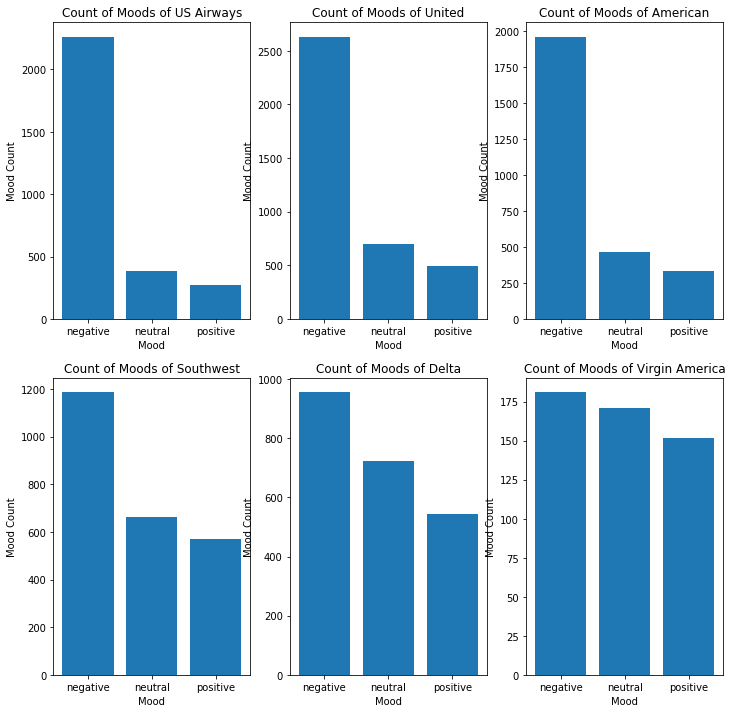

In [7]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import numpy


def plot_sub_sentiment(Airline):
    df=Tweets[Tweets['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+Airline)
    
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

From the above plots we see that the first three airlines are always skewed toward negative moods, while the later three airlines the sentiment is more balanced.


# Plotting negative reasons : overall and Airline wise

In [0]:
NR_Count=dict(Tweets['negativereason'].value_counts(sort=False))

In [0]:
def NR_Count(Airline):
    if Airline=='All':
        df=Tweets
    else:
        df=Tweets[Tweets['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unique_reason=list(Tweets['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pandas.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [0]:
def plot_reason(Airline):
    df=NR_Count(Airline)
    count=df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    plt.show()

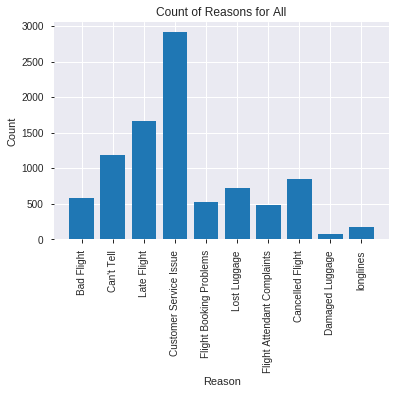

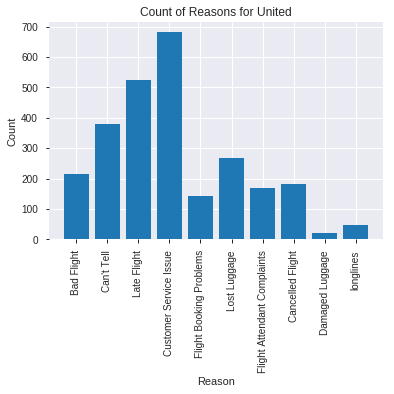

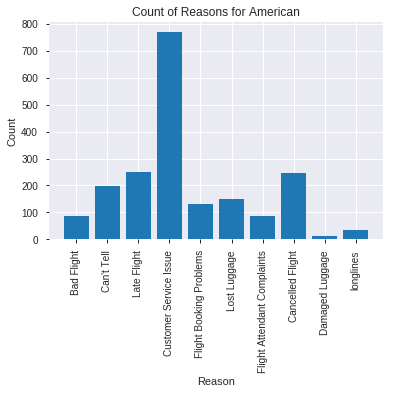

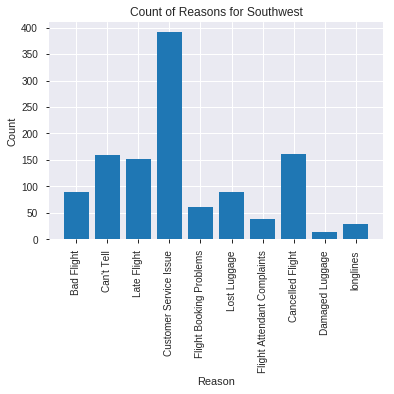

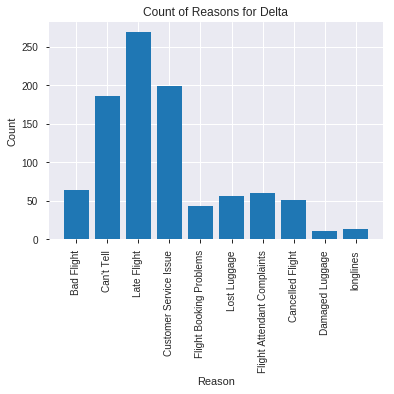

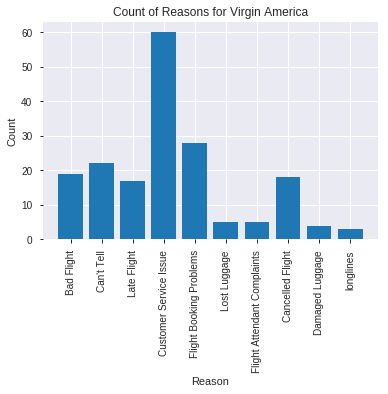

In [43]:

airline_names = ['All', 'United', 'American', 'Southwest', 'Delta', 'Virgin America']
for airline_name in airline_names:
    plot_reason(airline_name)

# Removing stopwords and getting Bag of Words containing negative, positive and neutral words

In [0]:
from wordcloud import WordCloud,STOPWORDS

In [0]:

def plt_wordcloud(sentiment, confidence=-1):
    df=Tweets[Tweets['airline_sentiment']==sentiment]
    if confidence!=-1:
        df = df[df['airline_sentiment_confidence']<confidence]
    words = ' '.join(df['text'])
    cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
    
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

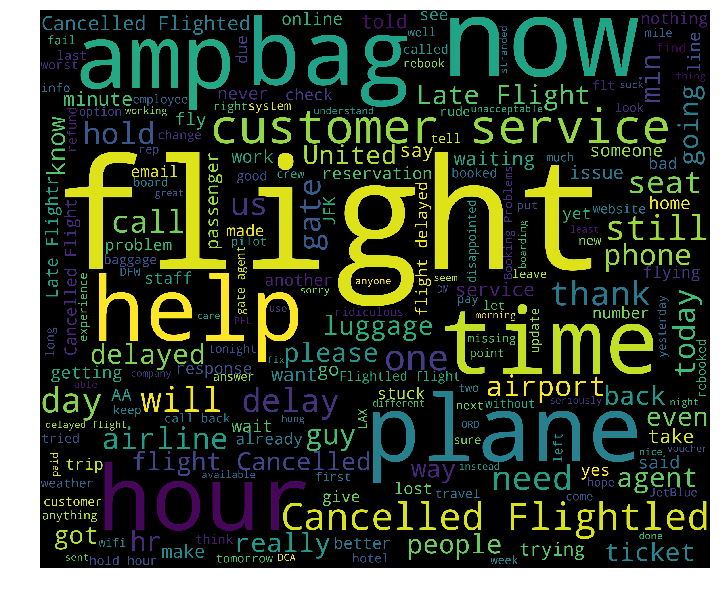

In [50]:
plt_wordcloud('negative')

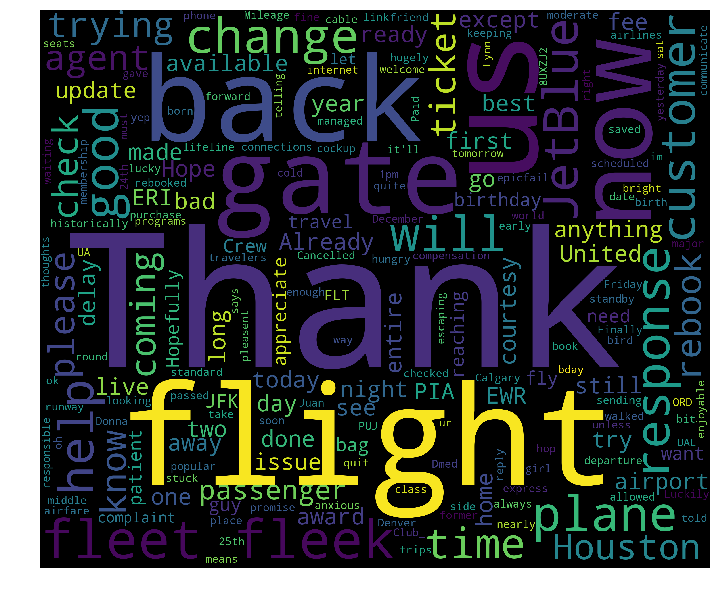

In [51]:
plt_wordcloud('negative',0.5)

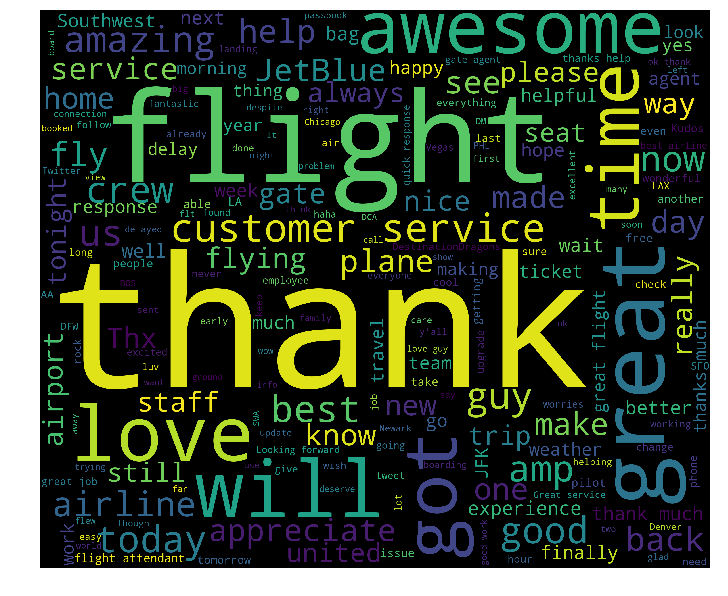

In [52]:
plt_wordcloud('positive')

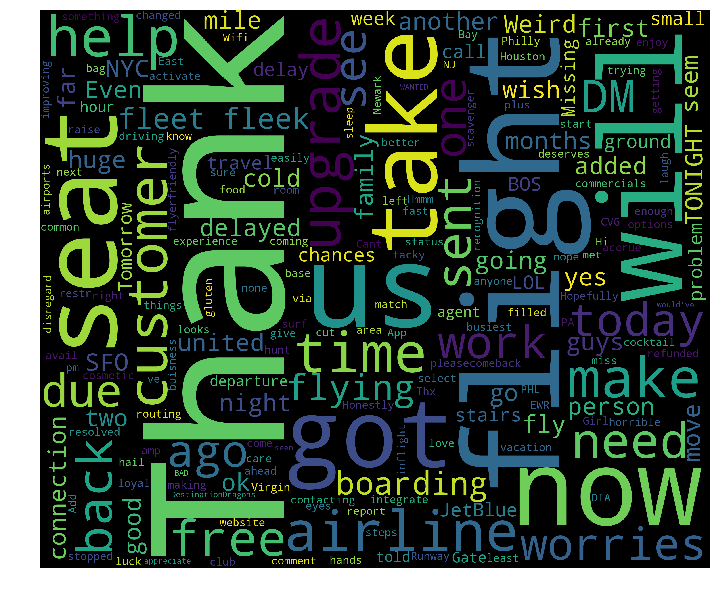

In [53]:
plt_wordcloud('positive',0.5)

Worth noticing, if we reduce the confidence interval of negative by 0.5 , we can notice few words like "Thank"  which is there as positive as well.


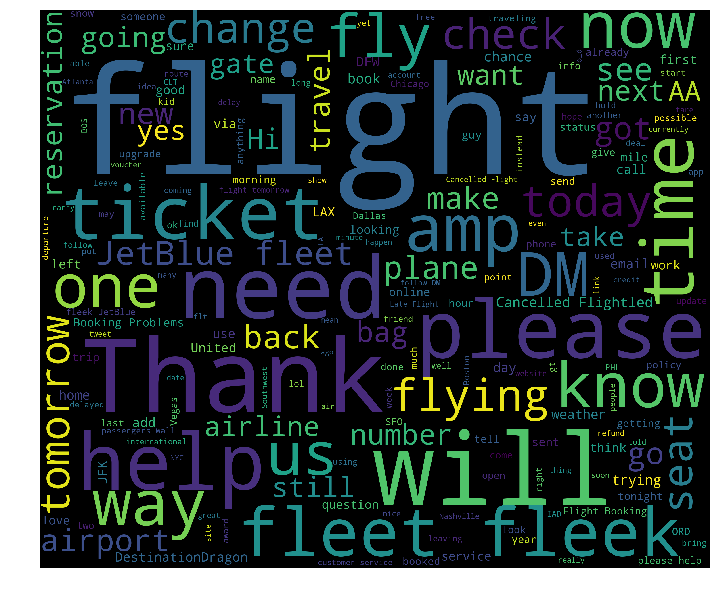

In [54]:
plt_wordcloud('neutral')

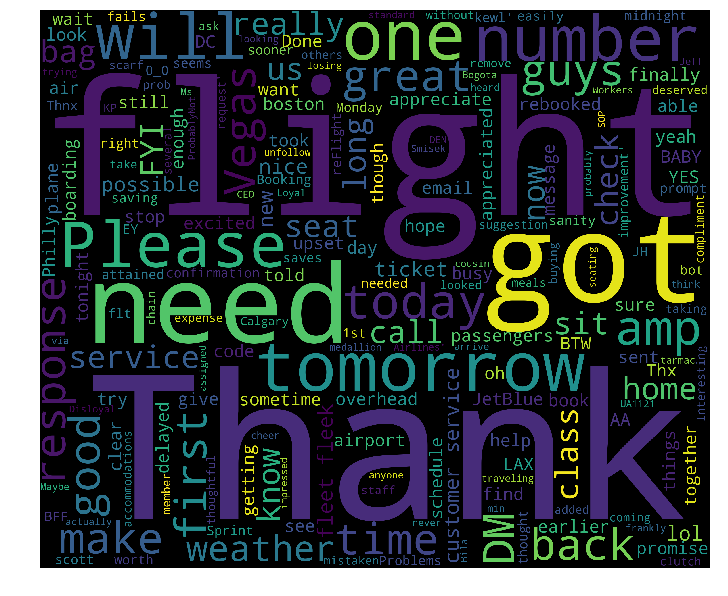

In [55]:
plt_wordcloud('neutral',0.5)

# **Preprocessing**

In [8]:
df = pandas.DataFrame(Tweets[['airline_sentiment','text']])
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


# Applying a label is_valid with values 'true' and 'false' as a seperator for train and validation data

In [9]:
df['is_valid'] = False
#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,airline_sentiment,text,is_valid
0,positive,@AmericanAir Thanks! He is.,False
1,neutral,@JetBlue Will do. I'll tell him you say hey.,False
2,positive,@SouthwestAir had an amazing experience with y...,False
3,positive,@JetBlue where's my selfie?,False
4,negative,@USAirways @AmericanAir worst customer servic...,False


In [10]:
df[-int(df.shape[0]*0.3):].is_valid = True 
df[-int(df.shape[0]*0.3):].tail()
df.to_csv('texts.csv')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [0]:
train_df = df[df['is_valid']==False]
valid_df = df[df['is_valid']==True]

# ULMFiT application begins....

In [0]:
from fastai.gen_doc.nbdoc import *
from fastai.text import *

In [0]:
path=""

In [0]:
for file in ['train_tok.npy', 'valid_tok.npy']:
    if os.path.exists(path+'tmp'+file): os.remove(path+'tmp'+file)

**Getting your data ready for modeling**

To get a DataBunch quickly, there are also several factory methods depending on how our data is structured. They are all detailed in text.data, here we'll use the method from_csv of the TextLMDataBunch (to get the data ready for a language model) and TextClasDataBunch (to get the data ready for a text classifier) classes.

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df=train_df, valid_df=valid_df, path=path)
# Classifier model data
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, vocab=data_lm.train_ds.vocab, bs=32)

This does all the necessary preprocessing behind the scene. For the classifier, we also pass the vocabulary (mapping from ids to words) that we want to use: this is to ensure that data_clas will use the same dictionary as data_lm.

Since this step can be a bit time-consuming, it's best to save the result with:

In [0]:

data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

This will create a 'tmp' directory where all the computed stuff will be stored. You can then reload those results with:

In [0]:
data_lm = load_data(path,'data_lm_export.pkl')
data_clas =load_data(path,'data_clas_export.pkl', bs=16)

**Fine-tuning a language model**

We can use the data_lm object we created earlier to fine-tune a pretrained language model. fast.ai has an English model with an AWD-LSTM architecture available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.

In [19]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.932683,4.197515,0.229678,10:44


Like a computer vision model, we can then unfreeze the model and fine-tune it.

In [25]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.634990,0.534212,0.796676,40:20


To evaluate your language model, you can run the Learner.predict method and specify the number of words you want it to guess.

In [80]:
learn.predict("This is a review about", n_words=10)

'This is a review about the public relations between Wall Street xxbos @united'

In [81]:

learn.predict("This was a great", n_words=10)

'This was a great thing ! xxbos @united Do fly CS for'

It doesn't make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model).

Finally we save the encoder to be able to use it for classification in the next section.



In [0]:
learn.save_encoder('ft_enc')

**Building a classifier**

We now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder. The learner object can be done in a single line.

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5)
learn.load_encoder('ft_enc')


In [22]:
data_clas.show_batch()


text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
"xxbos @southwestair $ xxunk xxunk 4 / 30 - 5 / 5 "" xxup xxunk : xxup rt xxunk : xxmaj if you 're trying to make travel reservations for xxmaj vegas on xxmaj may 2nd it 's too xxmaj late xxmaj flight """,neutral
xxbos xxup but @united just re - booked to xxup bos ; xxup xxunk ! ! now 3 hour bus to xxup xxunk home . xxmaj could have flown to xxup bdl & & back to xxup dc in same time . # unitedairlines,negative
"xxbos @united really ? 3 hr delay , 4 gate changes , & & you boarded us , sent us back up , & & boarded us again . xxmaj wo n't change our flight . xxmaj can we go now ?",negative


In [92]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.721703,0.590825,0.764344,09:35


Again, we can unfreeze the model and fine-tune it.

In [93]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.639315,0.562554,0.766166,11:39


In [23]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.647299,0.547412,0.766849,33:26


Again, we can predict on a raw text by using the Learner.predict method.

In [24]:
learn.predict("This was a great flight!")

(Category positive, tensor(2), tensor([0.0730, 0.0261, 0.9009]))